# SNooPy Basics

This notebook covers the basics of using SNooPy for its first intended use:  fitting type Ia supernova light-curves. This notebook covers:

1. Loading data into SNooPy and creating a `sn` object.
2. Examining the data structure and member functions
3. Choosing a model and fitting it to the data
4. Getting at the parameters of the fit
5. Basic scripting

## Loading data and creating a `sn` object

There are four ways to load data into SNooPy, all of which are accomplished using the same function:  `get_sn`.
First, you can put the data into an `ASCII` file using the format
that SNooPY can load (see the example `data/SN2006ax.txt` data file). Then just use `get_sn` to load it in and
assign it to a variable.

In [2]:
from snpy import get_sn
s = get_sn('data/SN2006ax.txt')
print type(s)

<class 'snpy.sn.sn'>


Second, you can save a `sn` object as a `pickle` file and then load it in again. Unlike the `ASCII` file, a `pickle`
file will contain the full "state" of the object, including any parameters you fit, or even data you assign to it. For example:

In [5]:
s.comment = "Hey this is pretty cool!"
s.save('SN2006ax.snpy')    # I usually use the .snpy file to denote a SNooPy save file
t = get_sn('data/SN2006ax.txt')
s = get_sn('SN2006ax.snpy')
print t.comment
print s.comment

AttributeError: Error:  attribute comment not defined

As you can see, the `save`d version has the comment we added. The third way to load data into SNooPy is to give
it a `URL` from the Open Supernova Catalog. Simply navigate to your favorite object's page and copy the
''Download all Data'' link, then give that `URL` to the `get_sn` function:

In [6]:
t = get_sn('https://sne.space/astrocats/astrocats/supernovae/output/json/SN2017cbv.json')
print t.name

and was not imported:
(u'C', '', '', '')
SN2017cbv


You'll likely get warnings about unrecognized photometry. SNooPy needs to assign a filter to each light-curve
in order to do things like K-corrections. If it can't figure out what photometric system is being presented, it
will skip it. 

The final way to get data into SNooPy is to have it
query the CSP database. This requires a VPN connection to one of the CSP servers (`csp2.lco.cl` or
`obs.carnegiescience.edu`) and also the password. This is a fall-back behaviour, so if you were trying to load
a datafile and got the name wrong, you'll be asked for a password. This is SNooPy trying to query the CSP database
for your file.

## Examining the data structure and member functions

As you can saw above, `s` and `t` are now variables of type `snpy.sn.sn`, which means they are "supernova" objects. Really, that just means they are objects that have positions on the sky (RA,DEC), redshifts, and lightcurves in a number of filters. So this could stand for any variable source, really. As a `python` object, they have several member variables. Here are the member data that were loaded from the `ASCII` file and OSC:

In [7]:
print s.name, s.ra, s.decl, s.z
print s.data
print ""
print t.name, t.ra, t.decl, t.z
print t.data

SN2006ax 171.014417 -12.291444 0.016727
{'B': <snpy.lc.lc instance at 0x1a116cb320>, 'g': <snpy.lc.lc instance at 0x1a116cb290>, 'i': <snpy.lc.lc instance at 0x1a116cc5f0>, 'H': <snpy.lc.lc instance at 0x1a116cc6c8>, 'J': <snpy.lc.lc instance at 0x1a116ccb48>, 'r': <snpy.lc.lc instance at 0x1a116cc3f8>, 'u': <snpy.lc.lc instance at 0x1a116cca70>, 'V': <snpy.lc.lc instance at 0x1a116cc320>, 'Y': <snpy.lc.lc instance at 0x1a116cefc8>}

SN2017cbv 218.143416667 -44.1340944444 0.003999
{'U_UVOT': <snpy.lc.lc instance at 0x1a12c46a70>, 'V_UVOT': <snpy.lc.lc instance at 0x1a12c46d88>, 'UVW1': <snpy.lc.lc instance at 0x1a12c46b90>, 'UVW2': <snpy.lc.lc instance at 0x1a16980bd8>, 'B_UVOT': <snpy.lc.lc instance at 0x1a169807e8>, 'UVM2': <snpy.lc.lc instance at 0x1a16980830>}


These are the basic data:  the name of the objects, the coordinates, redshfits, and `data`, which is a `python`
dictionary indexed by filter name. In the case of SN2006ax, we've got the CSP filter set (B,V,u,g,r,i,Y,J,H). In 
the case of SN2017cbv, we've got Swift UVOT photometry (U_UVOT,B_UVOT,V_UVOT,UVW1,UVW2,UVM2). These filter names
are important:  they correspond to filters SNooPy has it its database and uses to do K-corrections. The value of each
element in the `data` variable is another python object, `snpy.lc.lc`, which contains the data:

In [8]:
print s.data['B'].MJD
print s.data['B'].mag
print s.data['B'].e_mag

[815.647 816.771 818.69  819.717 821.598 821.601 823.681 824.683 828.518
 831.656 832.642 834.729 835.577 838.679 840.639 841.682 845.562 850.646
 858.587 861.582 866.545 867.643 870.589 871.557 872.547 890.572 891.505
 892.504 898.521]
[16.74  16.362 15.88  15.69  15.438 15.438 15.287 15.213 15.188 15.285
 15.335 15.468 15.534 15.809 15.98  16.102 16.53  17.078 17.726 17.862
 18.066 18.14  18.191 18.215 18.247 18.545 18.584 18.607 18.671]
[0.009 0.008 0.009 0.009 0.006 0.006 0.007 0.006 0.004 0.008 0.006 0.007
 0.007 0.011 0.008 0.007 0.008 0.007 0.009 0.012 0.015 0.02  0.013 0.013
 0.013 0.016 0.02  0.011 0.01 ]


That's just the light-curve data that came from the `ASCII` file. All other information generated by SNooPy 
ultimately comes from these. For example, with the sky coordinates (`s.ra, s.decl`), we can query IRSA for
the color excess due to Milky-Way extinction using the Schlafey & Finkbeiner (2011). Additionally, with
the heliocentric redshift
(`s.z`), one can compute the redshift in the CMB frame and also compute the distance using $\Lambda$CDM:

In [11]:
print s.EBVgal
print s.zcmb
print s.get_distmod(H0=75)

0.041
0.0179567162927
34.3106313562


The `get_distmod` function is an example of an object's membmer function, which uses the data to do cool stuff.
You can get a listing of all of them by running the `python` function `help` on any `sn` object:

In [12]:
help(s)

Help on sn in module snpy.sn object:

class sn(__builtin__.object)
 |  This class is the heart of SNooPy.  Create a supernova object by 
 |  calling the constructor with the name of the superova as the argument.  
 |  e.g::
 |  
 |     In[1]:  s = sn('SN1999T')
 |  
 |  if the supernova is in the SQL database, its lightcurve data will be loaded 
 |  into its member data.  Once the object is created, use its member data 
 |  and functions to do your work.  Of course, you can have multiple 
 |  supernovae defined at the same time.
 |  
 |  Args:
 |     name (str): A SN name, or a filename containing data.
 |     source (sqlbase): An instance of sqlmod.sqlbase class (for database access)
 |     ra (float): degrees Right-ascention (J2000), of object
 |     dec (float): degrees Declination (J2000) of object
 |     z (float): heliocentric redshift of object
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other)
 |      Check if the data in this instance is equal to the data in another.


### Plotting

There are serveral plotting functions:  `plot`, `plot_filters`, and `plot_color`, which are useful for 
visualizing the data. For this we need to turn on matplotlib's inline plotting for notebooks. Using SNooPy
interactively would pop up a new plotting window.

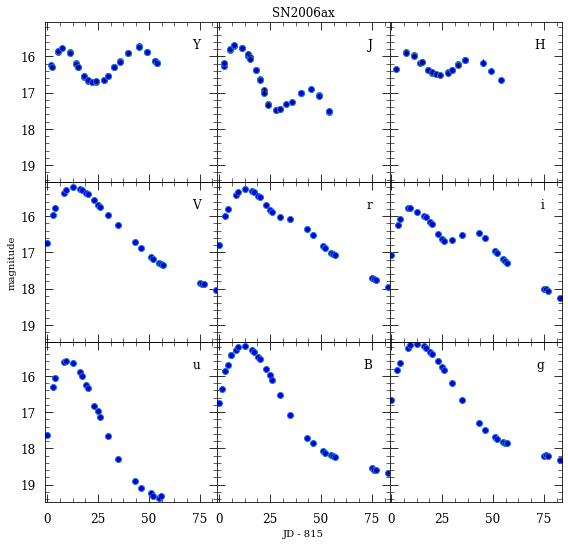

In [13]:
%matplotlib inline
s.plot()

The `plot_color` function takes two arguments:  the two filters with which to construct the color. For example, to plot a $B-V$ color-curve, give it `B` and `V` as arguments.

In [ ]:
cfig = s.plot_color('B','V')

Lastly, plotting the filters shows you the rest-frame (in blue) and observed (in red) filter functions. The
Hsiao SED template is shown in black. This is most useful at "high-redshift" where you might want to do cross-band fits (e.g., fit observed V with rest-band B). With
interactive use, the plot allows you to press the 'd' and 'D' keys to advance the Hsiao spectrum -1 and +1 days,
respectively.

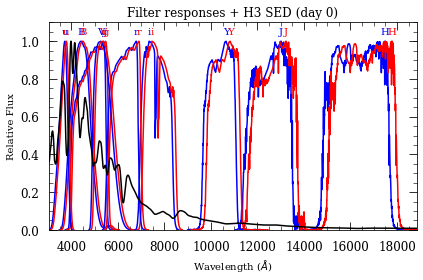

In [17]:
ffig = s.plot_filters()

## Choosing a Model and Fitting

Depending on what information you care most about, you'd choose a different model with which to fit the light-curves.
The choices currently are:

1. `EBV_model`:  The default (for now) fits a distance, decline rate ($\Delta m_{15}$), and extinction
based on the calibration from [Folatelli et al. (2010)](http://adsabs.harvard.edu/cgi-bin/abs/2010AJ....139..120F)

2. `EBV_model2`:  Same as `EBV_model`, but using an updated light-curve shape parameter ($s_{BV}$) and calibration
based on larger number of CSP objects as published in [Burns et al., (2011)](http://adsabs.harvard.edu/abs/2011AJ....141...19B)

3. `max_model`:  Fits a decline rate using either $\Delta m_{15}$ or $s_{BV}$ and a maximum magnitude for
each filter independently. This requires not calibration and is most useful if you want to use your own
(or fig your own).

4. `color_model`: Fits a decline rate ($\Delta m_{15}$ or $s_{BV}$), B-maximum, the color excess $E(B-V)$, and
the reddening slope $R_V$, assuming standard reddening laws (CCM, Fitzpatrick (1999), etc) as well as
the intrinsic color models of [Burns et al. (2014)](http://adsabs.harvard.edu/abs/2014arXiv1405.3934B)

In all cases, the time of B-maximum, `Tmax` must be determined as well. You choose the model using `choose_model`
member function with the name as an argument and optionally which shape parameter to use (`st` for
$s_{BV}$ or `dm15` for $\Delta m_{15}$). 

In [19]:
s.choose_model('max_model', stype='st')    # choose max_model with sBV as the parameter
t.choose_model('EBV_model2', stype='dm15') # choose reddening model with dm15 as parameter

SNooPy fits the photometry with light-curve "templates". For a given filter and $s_{BV}$ (or $\Delta m_{15}$),
the template gives the expected magnitude as a function of time. These templates are then adjusted using
whichever model you chose to fit the observed data. But the templates were constructed from well-observed 
SNe Ia using the CSP photometric system which were all transformed to the rest frame. To fit observed data
at redshfit $z$ in possibly different photometric systems, SNooPy needs to compute K-corrections, so it needs
to know what template filter to use to fit your observed filter. This is specified by the `restbands` member
variable. You can set these by hand, or run `set_restbands` after choosing the model. SNooPy will attempt to 
choose the filters that are closest to the observed filters when redshifted to the frame of the SN.

In [22]:
print s.restbands
print t.restbands
t.set_restbands()
print t.restbands

B -> B, g -> g, i -> i, H -> H, J -> J, r -> r, u -> u, V -> V, Y -> Y, 
U_UVOT -> u, V_UVOT -> V, UVW1 -> UVW1, UVW2 -> UVW2, B_UVOT -> Bs, UVM2 -> UVM2, 
U_UVOT -> u, V_UVOT -> V, UVW1 -> u, UVW2 -> u, B_UVOT -> B, UVM2 -> u, 


Lastly, we just fit the data. This is accomplished using the `fit` function. Behind the scenes, SNooPy will use the 
Levenberg-Marquardt (LM) algorithm to fit the multiple parameters. It does an initial fit to get the observed colors, then
"mangles" the Hsiao SED to match these colors, computes K-corrections, then adds these to the model and fits again.
If all goes well, you'll get a nice plot and the parameters will be set.

{'Ymax': 15.842060087787056, 'Hmax': 15.971813305066783, 'gmax': 14.993089954690129, 'Tmax': 827.5708591199451, 'rmax': 15.190763222026295, 'st': 0.9852468902342185, 'Jmax': 15.68835723909112, 'imax': 15.774614497402856, 'Vmax': 15.07446515450903, 'umax': 15.355199380703692, 'Bmax': 15.023869195622364}
{'Ymax': 0.010454652718832369, 'Hmax': 0.012344204962651291, 'gmax': 0.003917274059605268, 'Tmax': 0.02570067720487818, 'rmax': 0.004345575567760499, 'st': 0.003476583379030483, 'Jmax': 0.009906513198161736, 'imax': 0.006721175463223717, 'Vmax': 0.003846548230386774, 'umax': 0.007954028775163867, 'Bmax': 0.003923258377607436}


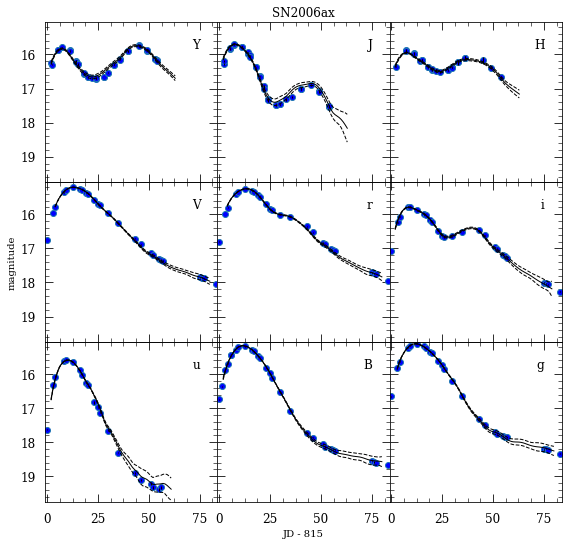

In [25]:
s.fit()

Sometimes however, you may have situations where the fit fails, either because the LM algorithm wanders off into
a region where the light-curves no longer constrain the model (e.g., Tmax is so low or high that your data no
longer covers the LC templates), or because two or more parameters are degenerate. In this case, you can hold a 
parameter fixed at a particular value and try to fit the rest. To show how this happens, we'll switch to the 
`color_model` and attempt to fit:

In [32]:
s.choose_model('color_model')
s.fit()

RuntimeError: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.

As the message indicates, two parameters are degenerate ($E(B-V)$ and $R_V$). In order to break the degeneracy, we
have to hold $R_V$ constant.

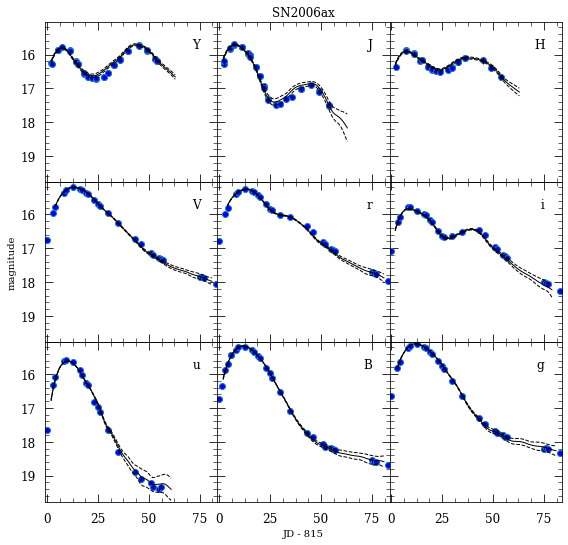

In [33]:
s.fit(Rv=3.1)

## Getting at the parameters of the fit

Once the fit is successful, the parameters and errors are stored in two dictionaries, which you can access from
the `sn` object:

In [34]:
print s.parameters
print s.errors

{'EBVhost': 0.02785035248858344, 'Rv': 3.1, 'Bmax': 14.90412465794083, 'Tmax': 827.5758678292093, 'st': 0.9870955904821636}
{'EBVhost': 0.002160376170491052, 'Tmax': 0.02938904331044535, 'Bmax': 0.006987143511077975, 'Rv': 0, 'st': 0.003943091460358404}


You can also access the parameters and errors using shortcuts. Each parameter appears as a member variable and its
error is prepended with `e_`:

In [35]:
print s.EBVhost, s.e_EBVhost

0.02785035248858344 0.002160376170491052


Note that the errors in the fit are tiny. That's because the photometry is very good (small error bars) and there's
lots of it. The model simply has
no "freedom" around the best-fit parameters, so the *statistical* errors are very small. 
But there are systematic errors. For the `color_model`, these are due to
variations in intrisic colors from SN to SN (they are not perfect "standard crayons")
as well as systematics due to light-curve shape. To get access to the systematic errors, you can use the `systematics` function:

In [36]:
s.systematics()

{'Bmax': 0.012, 'EBVhost': 0.06, 'Rv': None, 'Tmax': 0.34, 'st': 0.03}

All this can be sumamrized with the handy `summary` function. 

In [37]:
s.summary()

--------------------------------------------------------------------------------
SN  SN2006ax
z = 0.0167          zcmb = 0.0180          ra=171.01442         dec=-12.29144 
Data in the following bands: B,  g,  i,  H,  J,  r,  u,  V,  Y,  
Fit results (if any):
   EBVhost = 0.028  +/-  0.002  +/- 0.060 (sys)
   Rv = 3.100  +/-  0.000
   Bmax = 14.904  +/-  0.007  +/- 0.012 (sys)
   Tmax = 827.576  +/-  0.029  +/- 0.340 (sys)
   st = 0.987  +/-  0.004  +/- 0.030 (sys)


## Basic scripting

Everythign we did above could be put into a script and even run on multiple objects in a loop. I've 
resisted including such a 
script with SNooPy because I want people to understand what's going on and decide how they want to best use the
tools available. But that doesn't stop you from writing your own script.

The biggest difference between fitting interactively inside a SNooPy shell and writing it all in a script is
the way you refer to the filters and parameters. You really can't use the short-cuts I've built in. For example,
suppose we want to loop over each filter:

In [31]:
for band in s.data:
    print s.data[band].filter.name, s.data[band].filter.zp

B 14.327622015582193
g 15.104384482329905
i 14.530638636041541
H 13.510404351174268
J 13.801450487719434
r 14.892681150162781
u 12.987807524993464
V 14.439085042899116
Y 13.920804145340712


Here you may not know ahead of time what filters you have, so you need to refer to them with variables and so have to
use the dictionary interface to the data. Likewise if you have to loop over model parameters.